In [1]:
################################################################################
########################          Yelp Reviews          ######################## 
########################   Classification : Catboost    ######################## 
########################  Stars on Reviews: 1 & 2 vs 5  ########################
################################################################################

In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install gensim==3.8.3
!pip install catboost
!pip install optuna
import os
import random
import numpy as np
import pandas as pd
import time
from datetime import datetime, timedelta
from timeit import default_timer as timer
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim import models
import multiprocessing
import pickle
import joblib
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
import optuna
from optuna import Trial
optuna.logging.set_verbosity(optuna.logging.WARNING) # use INFO to see progress
import joblib
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import plotly.offline as py
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

my_dpi=96

     |████████████████████████████████| 24.2 MB 1.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
     |████████████████████████████████| 308 kB 34.6 MB/s 
     |████████████████████████████████| 81 kB 12.4 MB/s 
     |████████████████████████████████| 210 kB 33.1 MB/s 
     |████████████████████████████████| 78 kB 9.8 MB/s 
     |████████████████████████████████| 49 kB 8.2 MB/s 
     |████████████████████████████████| 146 kB 79.0 MB/s 
     |████████████████████████████████| 112 kB 24.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=dbb53507d655510f51143cf1f2f00d485218c649fe32839cc96c100386626e53
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [4]:
print('CUDA and NVIDIA GPU Information')
!/usr/local/cuda/bin/nvcc --version
!nvidia-smi

print('\n')
cores = multiprocessing.cpu_count()
print('Number of cores:', cores)

CUDA and NVIDIA GPU Information
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Fri May 13 05:46:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|            

In [5]:
# Set seed 
seed_value = 42
os.environ['YelpReviews_ML'] = str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

In [6]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/

/content/drive/MyDrive/Yelp_Reviews/Data


In [7]:
# Read tokenized reviews with stars filtered to 1, 2 and 5
df = pd.read_parquet('YelpReviews_NLP_125stars_tokenized.parquet')
print('Number of rows and columns:', df.shape)
df.head()

Number of rows and columns: (1541486, 2)


,stars_reviews,cleanReview
index,,
2,5.0,"[wonderful, place, get, lunch, staff, friendly..."
3,5.0,"[dedicated, loving, memory, gary, feldman, gre..."
5,5.0,"[love, place, everything, menu, delicious, lik..."
7,5.0,"[truely, hidden, gem, place, greatest, buffalo..."
9,5.0,"[seriously, great, fresh, fantastic, food, spo..."


In [8]:
# Process format of reviews for word2vec
df = df.copy()
df["cleanReview"]= [[f'"{j}"' for j in i] for i in df["cleanReview"]]
df.head()

,stars_reviews,cleanReview
index,,
2,5.0,"[""wonderful"", ""place"", ""get"", ""lunch"", ""staff""..."
3,5.0,"[""dedicated"", ""loving"", ""memory"", ""gary"", ""fel..."
5,5.0,"[""love"", ""place"", ""everything"", ""menu"", ""delic..."
7,5.0,"[""truely"", ""hidden"", ""gem"", ""place"", ""greatest..."
9,5.0,"[""seriously"", ""great"", ""fresh"", ""fantastic"", ""..."


In [9]:
# Recode to binary
df = df.copy()
df['stars_reviews'].mask(df['stars_reviews'] == 1, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 2, 0, inplace=True)
df['stars_reviews'].mask(df['stars_reviews'] == 5, 1, inplace=True)

print('Number of reviews per group:')
df[['stars_reviews']].value_counts() 

Number of reviews per group:


stars_reviews
0.0              770743
1.0              770743
dtype: int64

In [10]:
df1 = df[df.stars_reviews==0]
df1 = shuffle(df1)
df1 = df1.sample(n=414937)

In [11]:
df2 = df[df.stars_reviews==1]
df2 = shuffle(df2)
df2 = df2.sample(n=414937)
df = pd.concat([df1, df2])
df = shuffle(df)

del df1, df2

df.shape

(829874, 2)

In [12]:
# Set up label and features
label = df[['stars_reviews']]
features = df.cleanReview

In [13]:
%cd /content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models/

/content/drive/MyDrive/Yelp_Reviews/Data/word2vec_models


In [14]:
# Load model
word2vec_path = 'gensim_w2vModel_review125_50epochs.bin'
model = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)
wv = model.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



In [15]:
# Creating Mean Word Embeddings using Mean Embedding Vectorizer class
class W2vVectorizer(object):
    """
    This class is used to provide mean word vectors for review documents. 
    This is done in the transform function which is used to generate mean vectors in model pipelines.
    The class has both fit and transform functions so that it may be used in an sklearn Pipeline.
    """
    
    def __init__(self, w2v):
        self.w2v = w2v
        
        #If using GloVe the model is in a dictionary format
        if isinstance(w2v, dict):
            if len(w2v) == 0:
                self.dimensions = 0
            else:
                self.dimensions = len(w2v[next(iter(w2v))])
        #Otherwise, using gensim keyed vector
        else:
            self.dimensions = w2v.vector_size
    
    # Need to implement a fit method as required for sklearn Pipeline.
    def fit(self, X, y):
        return self

    def transform(self, X):
        """
        This function generates a w2v vector for a set of tokens. This is done by taking 
        the mean of each token in the review.
        """
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                    or [np.zeros(self.dimensions)], axis=0) for words in X])

In [16]:
print('Pipeline for Word2Vec:')
pl  = Pipeline([("W2vVectorizer", W2vVectorizer(wv))])
pl

Pipeline for Word2Vec:


Pipeline(steps=[('W2vVectorizer',
                 <__main__.W2vVectorizer object at 0x7ff34f764d90>)])

In [17]:
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL


In [18]:
def train_model_for_study(features, label, model):
    X_train, X_test, y_train, y_test = train_test_split(
        features, 
        label, 
        test_size=0.2, 
        stratify=label,
        random_state=seed_value
    )

    X_train = pl.fit_transform(X_train)
    X_test = pl.fit_transform(X_test)
    
    # Start timer for each trial
    start = timer()

    model.fit(
        X_train, 
        y_train.values.ravel(),
        eval_set=[(X_test, y_test.values.ravel())])

    # Predictions
    y_pred_val = model.predict_proba(X_test)
    cv_scores = log_loss(y_test, y_pred_val)     
    print('- Validation logloss:', np.mean(cv_scores))  
    run_time = timer() - start

    return np.mean(cv_scores)       

In [19]:
################################################################################
######################     Catboost Optuna HPO  ################################
######################         100 trials       ################################
################################################################################
def cat_hpo(trial):
    """
    Objective function to tune a `CatBoostClassifier` model.
    """
    joblib.dump(study, 'Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl')

    # Define parameter grid
    params_catboost_optuna = {
      'iterations': trial.suggest_int('iterations', 100, 500, step=10),
      'depth': trial.suggest_int('depth', 3, 10),
      'l2_leaf_reg': trial.suggest_float('l2_leaf_reg',1e-8, 1e-1, log=True), 
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.000001,0.1),  
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 20),
      'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 20),  
      'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
    }

    model = CatBoostClassifier(
        loss_function='Logloss',
        task_type='GPU', 
        random_state=seed_value,
        **params_catboost_optuna,
    )
    
    return train_model_for_study(features, label, model)

In [20]:
# Begin HPO trials 
# Start timer for experiment
start_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
if os.path.isfile('Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl'):
    study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl')
else:
    study = optuna.create_study(direction='minimize')
study.optimize(cat_hpo, n_trials=100)

# End timer for experiment
end_time = datetime.now()
print("%-20s %s" % ("Start Time", start_time))
print("%-20s %s" % ("End Time", end_time))
print(str(timedelta(seconds=(end_time-start_time).seconds)))
print('\n')
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)
print('Lowest LogLoss', study.best_value)

Streaming output truncated to the last 5000 lines.
304:	learn: 0.1335290	test: 0.1595517	best: 0.1595517 (304)	total: 8.49s	remaining: 139ms
305:	learn: 0.1334343	test: 0.1595287	best: 0.1595287 (305)	total: 8.52s	remaining: 111ms
306:	learn: 0.1333578	test: 0.1595112	best: 0.1595112 (306)	total: 8.54s	remaining: 83.5ms
307:	learn: 0.1332762	test: 0.1594920	best: 0.1594920 (307)	total: 8.57s	remaining: 55.7ms
308:	learn: 0.1332095	test: 0.1594747	best: 0.1594747 (308)	total: 8.6s	remaining: 27.8ms
309:	learn: 0.1330866	test: 0.1594661	best: 0.1594661 (309)	total: 8.63s	remaining: 0us
bestTest = 0.1594661456
bestIteration = 309
- Validation logloss: 0.16042108179727405
0:	learn: 0.6359443	test: 0.6361527	best: 0.6361527 (0)	total: 54.8ms	remaining: 16.9s
1:	learn: 0.5859534	test: 0.5863539	best: 0.5863539 (1)	total: 109ms	remaining: 16.8s
2:	learn: 0.5427806	test: 0.5432815	best: 0.5432815 (2)	total: 154ms	remaining: 15.7s
3:	learn: 0.5047027	test: 0.5053351	best: 0.5053351 (3)	total: 1

In [21]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


In [22]:
# Output from HPO trials
trials_df = study.trials_dataframe()
trials_df.rename(columns={'number':'iteration'}, inplace=True)
trials_df.rename(columns={'value':'logloss'},inplace=True)
trials_df.rename(columns={'params_depth':'depth'}, inplace=True)
trials_df.rename(columns={'params_iterations':'n_estimators'}, inplace=True)
trials_df.rename(columns={'params_l2_leaf_reg':'l2_leaf_reg'}, inplace=True)
trials_df.rename(columns={'params_learning_rate':'learning_rate'}, inplace=True)
trials_df.rename(columns={'params_min_data_in_leaf':'min_data_in_leaf'}, inplace=True)
trials_df.rename(columns={'params_one_hot_max_size':'one_hot_max_size'}, inplace=True)
trials_df.rename(columns={'params_scale_pos_weight':'scale_pos_weight'}, inplace=True)

trials_df = trials_df.sort_values('logloss', ascending=True)
print(trials_df) 

# Write processed data to csv
trials_df.to_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment.csv', index=False)

    iteration   logloss             datetime_start          datetime_complete  \
52         52  0.160409 2022-05-13 07:06:50.583015 2022-05-13 07:08:25.880561   
84         84  0.160421 2022-05-13 07:57:14.258533 2022-05-13 07:58:50.103699   
68         68  0.160633 2022-05-13 07:31:59.624199 2022-05-13 07:33:35.005860   
91         91  0.160700 2022-05-13 08:08:15.149929 2022-05-13 08:09:51.289368   
69         69  0.160773 2022-05-13 07:33:35.005984 2022-05-13 07:35:10.167786   
..        ...       ...                        ...                        ...   
7           7  0.688825 2022-05-13 05:57:56.528254 2022-05-13 05:59:32.976857   
1           1  0.689896 2022-05-13 05:48:42.866717 2022-05-13 05:50:18.933607   
5           5  0.690068 2022-05-13 05:54:52.296596 2022-05-13 05:56:26.410358   
60         60  0.691818 2022-05-13 07:19:35.925069 2022-05-13 07:21:06.003837   
23         23  0.692705 2022-05-13 06:22:29.600686 2022-05-13 06:24:01.846138   

                 duration  

In [23]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations


In [24]:
# Plot_optimization_histor: shows the scores from all trials as well as the best score so far at each point.
fig = optuna.visualization.plot_optimization_history(study)
py.plot(fig, filename='optimizationHistory_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [25]:
# plot_parallel_coordinate: interactively visualizes the hyperparameters and scores
fig = optuna.visualization.plot_parallel_coordinate(study)
py.plot(fig, filename='parallelCoordinate_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [26]:
# plot_slice: shows the change of the hyperparamters space over the search. 
fig = optuna.visualization.plot_slice(study)
py.plot(fig, filename='slice_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [27]:
# plot_contour: plots parameter interactions on an interactive chart. You can choose which hyperparameters you would like to explore.
fig = optuna.visualization.plot_contour(study, params=['min_data_in_leaf', 
                                                       'depth', 
                                                       'learning_rate', 
                                                       'one_hot_max_size'])
py.plot(fig, filename='contour_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [28]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


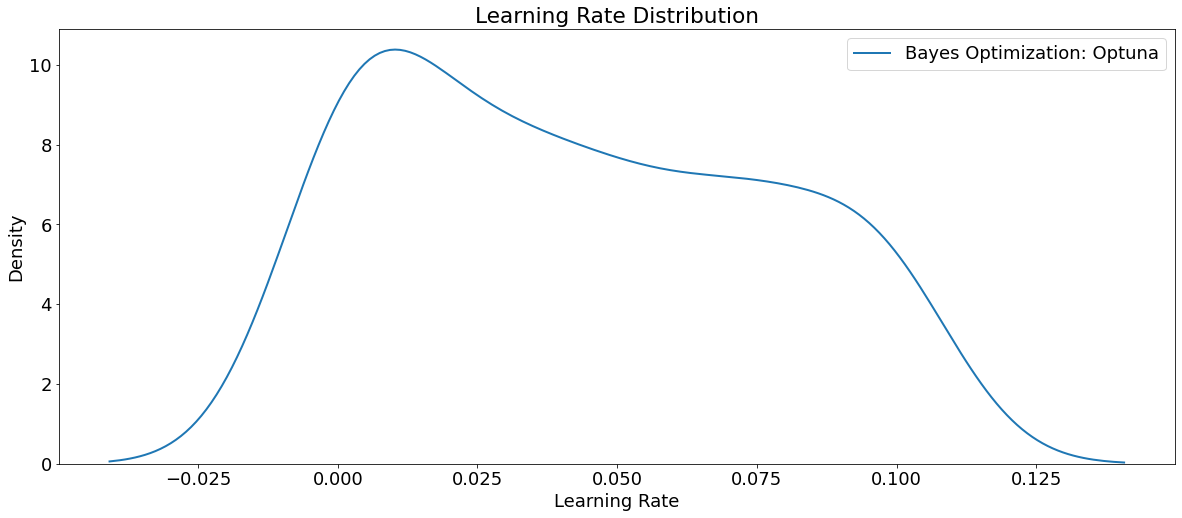

In [29]:
# Density plots of the learning rate distributions 
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
sns.kdeplot(trials_df['learning_rate'], label = 'Bayes Optimization: Optuna', 
            linewidth = 2)
plt.legend(loc = 1)
plt.xlabel('Learning Rate'); plt.ylabel('Density'); plt.title('Learning Rate Distribution');
plt.show()

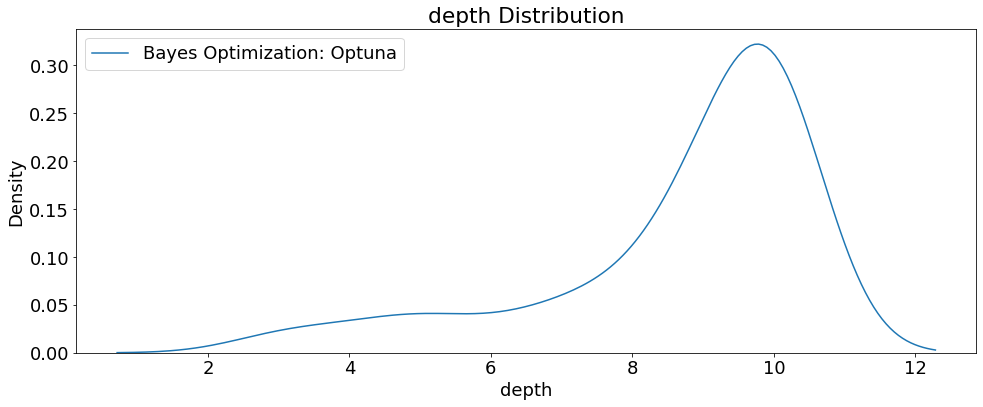

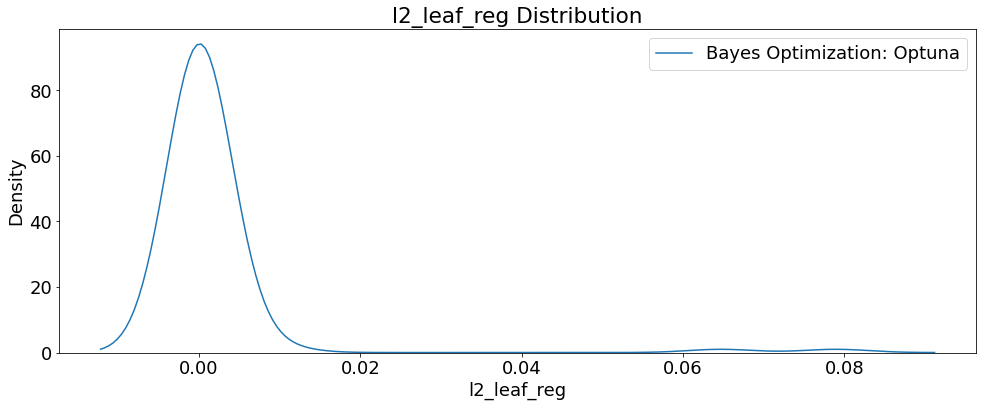

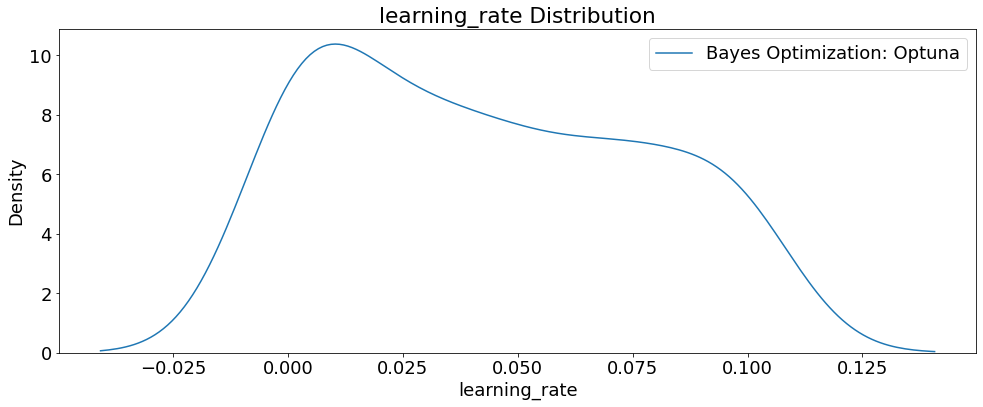

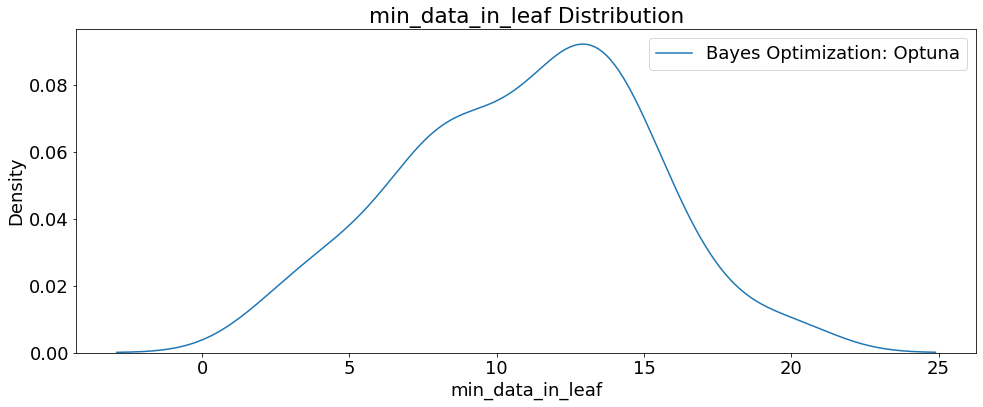

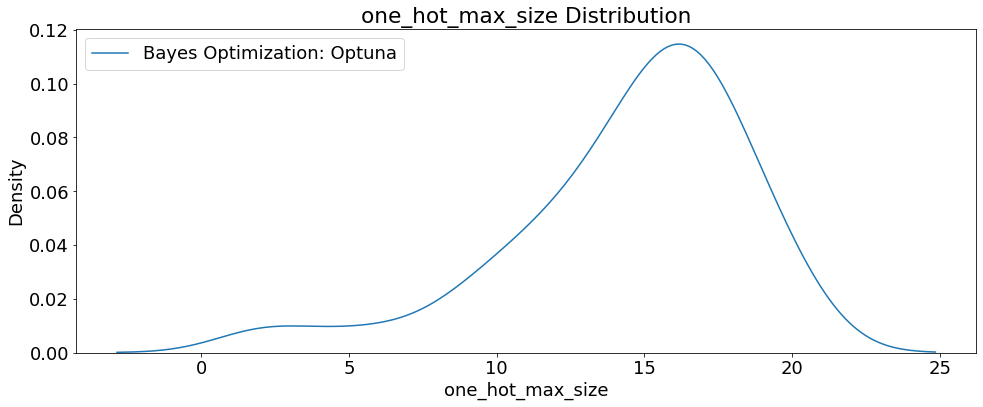

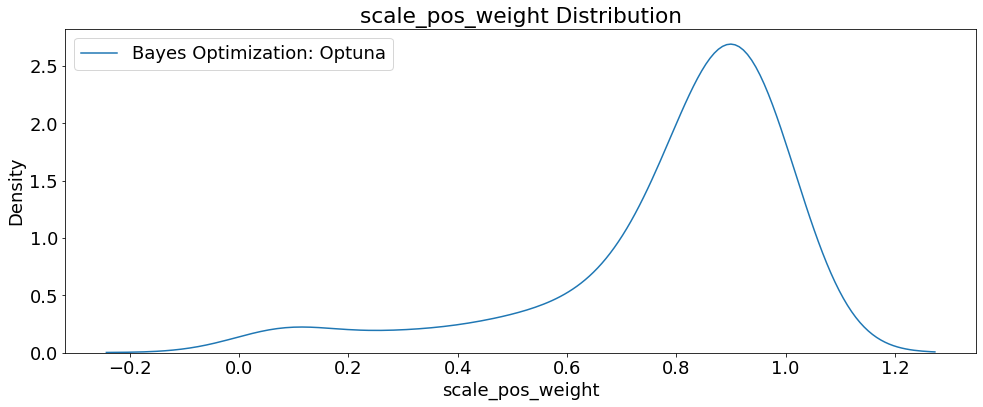

In [30]:
# Create plots of Hyperparameters that are numeric 
for i, hpo in enumerate(trials_df.columns):
    if hpo not in ['iteration', 'logloss', 'datetime_start', 'datetime_complete',
                   'duration','n_estimators', 'state']:
        plt.figure(figsize = (14, 6))
        # Plot the random search distribution and the bayes search distribution
        if hpo != 'loss':
            sns.kdeplot(trials_df[hpo], label = 'Bayes Optimization: Optuna')
            plt.legend(loc = 0)
            plt.title('{} Distribution'.format(hpo))
            plt.xlabel('{}'.format(hpo)); plt.ylabel('Density')
            plt.tight_layout()
            plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



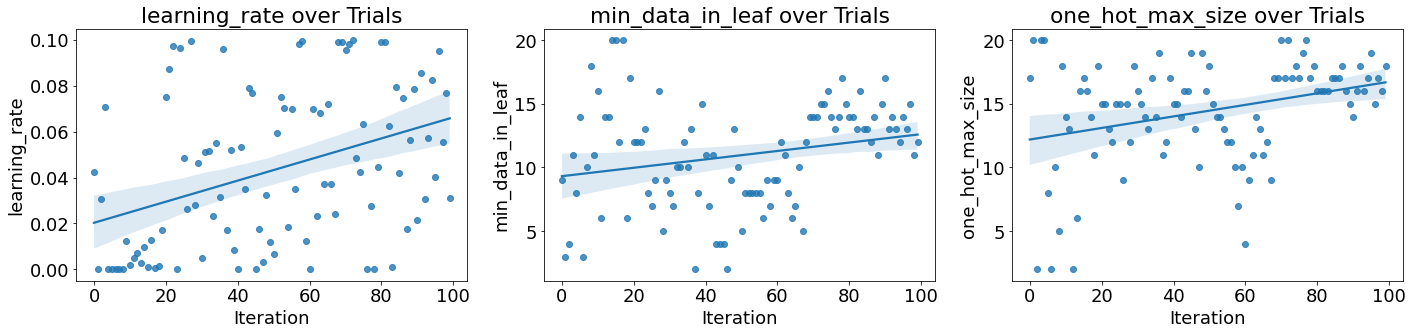

In [31]:
# Plot quantitive hyperparameters
fig, axs = plt.subplots(1, 3, figsize = (20, 5))
i = 0
for i, hpo in enumerate(['learning_rate', 'min_data_in_leaf', 
                         'one_hot_max_size']):
        # Scatterplot
        sns.regplot('iteration', hpo, data = trials_df, ax = axs[i])
        axs[i].set(xlabel = 'Iteration', ylabel = '{}'.format(hpo), 
                   title = '{} over Trials'.format(hpo))
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



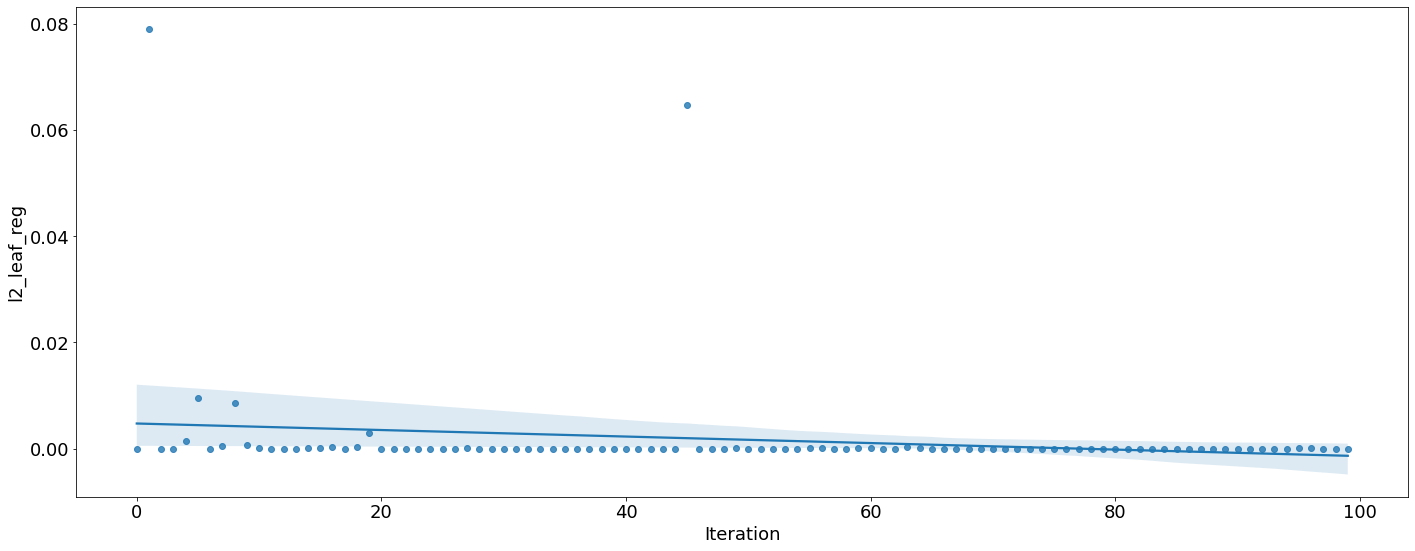

In [32]:
# Scatterplot of regularization hyperparameters
plt.figure(figsize = (20, 8))
plt.rcParams['font.size'] = 18
ax = sns.regplot('iteration', 'l2_leaf_reg', data = trials_df, label = 'Bayes Optimization') 
ax.set(xlabel = 'Iteration', ylabel = 'l2_leaf_reg')                 
plt.tight_layout()
plt.show()

In [33]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations/

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_Explanations


In [34]:
# Visualize parameter importances
fig = optuna.visualization.plot_param_importances(study)
py.plot(fig, filename='paramImportance_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [35]:
# Visualize empirical distribution function
fig = optuna.visualization.plot_edf(study)
py.plot(fig, filename='edf_Catboost_Optuna_100_GPU_balancedSizeSentiment.html')
fig.show()

In [36]:
# Arrange best parameters to fit model for model metrics
params=study.best_params   
params['random_state'] = seed_value
params['loss_function']= 'Logloss'
params

{'depth': 10,
 'iterations': 290,
 'l2_leaf_reg': 1.0901217292554234e-05,
 'learning_rate': 0.0751512132184808,
 'loss_function': 'Logloss',
 'min_data_in_leaf': 8,
 'one_hot_max_size': 14,
 'random_state': 42,
 'scale_pos_weight': 0.9977759070485601}

In [37]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL/


study = joblib.load('Catboost_Optuna_100_GPU_balancedSizeSentiment.pkl')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/Model_PKL


In [38]:
label = df[['stars_reviews']]

features = df.cleanReview

In [39]:
# Partition data for train/test 
X_train, X_test, y_train, y_test = train_test_split(features, label,
                                                    test_size=0.2, stratify=label)

In [40]:
# Vectorize reviews in train/test sets
X_train = pl.fit_transform(X_train)
X_test = pl.fit_transform(X_test)

In [41]:
# Re-create the best model and train on the training data
best_model = CatBoostClassifier(early_stopping_rounds=100,
                               rsm=1, 
                               task_type='GPU', 
                               logging_level='Silent', 
                                **params)
# Fit the model
#.ravel()
best_model.fit(X_train, y_train)

# Save model
Pkl_Filename = 'Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl'  

with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(best_model, file)

# =============================================================================
# # To load saved model
# model = joblib.load('Catboost_HPO_Optuna_trials100_GPU_balancedSizeSentiment.pkl')
# print(model)
# =============================================================================

In [42]:
print('Results from Catboost HPO Optuna 100 GPU trials:')
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

print('\n')
print('Classification Report: Train')
clf_rpt = classification_report(y_train, y_train_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Train')
print(confusion_matrix(y_train, y_train_pred))
print('\n')
print('Classification Report: Test')
clf_rpt = classification_report(y_test, y_test_pred)
print(clf_rpt)
print('\n')
print('Confusion matrix: Test')
print(confusion_matrix(y_test, y_test_pred))
print('\n')

print('Accuracy score: train: %.3f, test: %.3f' % (
        accuracy_score(y_train, y_train_pred),
        accuracy_score(y_test, y_test_pred)))
print('Precision score: train: %.3f, test: %.3f' % (
        precision_score(y_train, y_train_pred),
        precision_score(y_test, y_test_pred)))
print('Recall score: train: %.3f, test: %.3f' % (
        recall_score(y_train, y_train_pred),
        recall_score(y_test, y_test_pred)))
print('F1 score: train: %.3f, test: %.3f' % (
        f1_score(y_train, y_train_pred),
        f1_score(y_test, y_test_pred)))

Results from Catboost HPO Optuna 100 GPU trials:


Classification Report: Train
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95    331950
         1.0       0.95      0.95      0.95    331949

    accuracy                           0.95    663899
   macro avg       0.95      0.95      0.95    663899
weighted avg       0.95      0.95      0.95    663899



Confusion matrix: Train
[[314846  17104]
 [ 17996 313953]]


Classification Report: Test
              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94     82987
         1.0       0.94      0.94      0.94     82988

    accuracy                           0.94    165975
   macro avg       0.94      0.94      0.94    165975
weighted avg       0.94      0.94      0.94    165975



Confusion matrix: Test
[[77971  5016]
 [ 5295 77693]]


Accuracy score: train: 0.947, test: 0.938
Precision score: train: 0.948, test: 0.939
Recall score: train: 0.946, test

In [43]:
# Write results to ML Results
%cd /content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions/

# Access results
trials_df = pd.read_csv('Catboost_Optuna_100_GPU_balancedSizeSentiment.csv')

/content/drive/MyDrive/Yelp_Reviews/ML/Classification/Catboost/ReviewStars/trialOptions


In [44]:
# Evaluate on the testing data 
print('The best model from optimization scores {:.5f} Accuracy on the test set.'.format(accuracy_score(y_test, y_test_pred)))
print('This was achieved using these conditions:')
print(trials_df.iloc[0])

The best model from optimization scores 0.93788 Accuracy on the test set.
This was achieved using these conditions:
iteration                                    52
logloss                                0.160409
datetime_start       2022-05-13 07:06:50.583015
datetime_complete    2022-05-13 07:08:25.880561
duration                 0 days 00:01:35.297546
depth                                        10
n_estimators                                290
l2_leaf_reg                            0.000011
learning_rate                          0.075151
min_data_in_leaf                              8
one_hot_max_size                             14
scale_pos_weight                       0.997776
state                                  COMPLETE
Name: 0, dtype: object
